In [77]:
import os
import math
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
% matplotlib inline  
from PIL import Image
import cv2
from scipy.stats.kde import gaussian_kde

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from tensorboardX import SummaryWriter

import logging
import imp
imp.reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%I:%M:%S')

In [122]:
class MLTData():
    def __init__(self, batch_size=32, image_size=[256, 128], orig_image_size=[480, 640], train_proportion=1, 
                 statistics='basic', direction_type='gt'):
        self.name = 'mlt'
        self.img_dir = '/media/yi/DATA/data-orig/MLT/image'
        self.box_dir = '/home/yi/code/few_shot/mlt/box'
        self.meta = self.get_meta(self.img_dir, self.box_dir)
 
        self.train_meta = self.assign_meta('train')
        self.test_meta = self.assign_meta('test')
        
        self.batch_size = batch_size
        self.im_size = image_size
        self.orig_im_size = orig_image_size
        self.train_proportion = train_proportion
        self.statistics = statistics
        self.direction_type = direction_type
        num_image = len(self.train_meta['img'])
        self.train_meta['img'] = self.train_meta['img'][0:int(num_image * train_proportion)]
        self.train_meta['box'] = self.train_meta['box'][0:int(num_image * train_proportion)]
        self.train_idx = np.random.permutation(len(self.train_meta['img']))
        self.train_cnt = 0
        self.test_idx = np.random.permutation(len(self.test_meta['img']))
        self.test_cnt = 0
        
        print('number of training image: %d, number of testing image: %d' % 
              (len(self.train_meta['img']), len(self.test_meta['img'])))
        if statistics == 'basic':
            self.show_basic_statistics('train')
            self.show_basic_statistics('test')
        else:
            self.show_full_statistics('train')
            self.show_full_statistics('test')
        
        self.class_map = {3:0, 4:1, 5:2, 6:3, 13:4, 24:5}
        self.inverse_class_map = {0:'Bed', 1:'Chair', 2:'Sofa', 3:'Table', 4:'Desks', 5:'Television'}
        
    def get_meta(self, img_dir, box_dir):
        meta = {}
        meta['img'], meta['box'] = [], []
        for sub_dir in os.listdir(box_dir):
            box_files = os.listdir(os.path.join(box_dir, sub_dir))
            box_files.sort(key=lambda f: int(filter(str.isdigit, f)))
            box_file_names = [os.path.join(box_dir, sub_dir, f) for f in box_files]
            img_files = []
            for f in box_files:
                file_name, file_ext = os.path.splitext(f)
                img_files.append(file_name + '_color.jpg')
            img_file_names = [os.path.join(img_dir, sub_dir, f) for f in img_files]
            meta['img'].extend(img_file_names)
            meta['box'].extend(box_file_names)
        return meta
    
    def assign_meta(self, status='train'):
        num_image = len(self.meta['img'])
        if status == 'train':
            meta = {}
            meta['img'] = self.meta['img'][0:int(num_image * 0.7)]
            meta['box'] = self.meta['box'][0:int(num_image * 0.7)]
        else:
            meta = {}
            meta['img'] = self.meta['img'][int(num_image * 0.7):]
            meta['box'] = self.meta['box'][int(num_image * 0.7):]
        return meta
    
    def show_basic_statistics(self, status='train'):
        if status == 'train':
            box_meta = self.train_meta['box']
        else:
            box_meta = self.test_meta['box']
        box = []
        for box_file_name in box_meta:
            with open(box_file_name) as txt_file:
                box_info = txt_file.readlines()
            for row in box_info:
                row = row.strip().split(' ')
                box.append(row)
        box = np.array(box).astype(np.int)

        cls = box[:, 4]
        box = box[:, 0:4]
        cls_labels = set(list(cls))
        count = dict()
        max_count = 0
        total_count = 0
        for cls_label in cls_labels:
            count[cls_label] = (cls == cls_label).sum()
            if count[cls_label] > max_count:
                max_count = count[cls_label]
            total_count = total_count + count[cls_label]
        print(status, count, max_count * 1.0 / total_count)
        
    def show_full_statistics(self, status='train'):
        if status == 'train':
            box_meta = self.train_meta['box']
        else:
            box_meta = self.test_meta['box']
        box = []
        for box_file_name in box_meta:
            with open(box_file_name) as txt_file:
                box_info = txt_file.readlines()
            for row in box_info:
                row = row.strip().split(' ')
                box.append(row)
        box = np.array(box).astype(np.int)

        cls = box[:, 4]
        box = box[:, 0:4]
        cls_labels = set(list(cls))
        count = dict()
        max_count = 0
        total_count = 0
        for cls_label in cls_labels:
            count[cls_label] = (cls == cls_label).sum()
            if count[cls_label] > max_count:
                max_count = count[cls_label]
            total_count = total_count + count[cls_label]
        print(status, count, max_count * 1.0 / total_count)
        
        x = (box[:, 0] + box[:, 2]) / 2.0 / 640
        y = (box[:, 1] + box[:, 3]) / 2.0 / 480
        w = (box[:, 2] - box[:, 0]) * 1.0 / 640
        h = (box[:, 3] - box[:, 1]) * 1.0 / 480
        print(np.min(x), np.max(x), np.mean(x), np.median(x))
        print(np.min(y), np.max(y), np.mean(y), np.median(y))
        print(np.min(w), np.max(w), np.mean(w), np.median(w))
        print(np.min(h), np.max(h), np.mean(h), np.median(h))
        fig = plt.figure()
        ax = fig.add_subplot(1, 2, 1)
        ax.scatter(x, y)
        ax = fig.add_subplot(1, 2, 2)
        ax.scatter(w, h)
        
        num_bins = 100
        fig = plt.figure()
        counts, bin_edges = np.histogram(x, bins=num_bins, range=[0, 1], normed=True)
        cdf = np.cumsum(counts)
        ax = fig.add_subplot(1, 4, 1)
        ax.plot(bin_edges[1:], cdf)
        counts, bin_edges = np.histogram(y, bins=num_bins, range=[0, 1], normed=True)
        cdf = np.cumsum(counts)
        ax = fig.add_subplot(1, 4, 2)
        ax.plot(bin_edges[1:], cdf)
        counts, bin_edges = np.histogram(w, bins=num_bins, range=[0, 1], normed=True)
        cdf = np.cumsum(counts)
        ax = fig.add_subplot(1, 4, 3)
        ax.plot(bin_edges[1:], cdf)
        counts, bin_edges = np.histogram(h, bins=num_bins, range=[0, 1], normed=True)
        cdf = np.cumsum(counts)
        ax = fig.add_subplot(1, 4, 4)
        ax.plot(bin_edges[1:], cdf)
        
        fig = plt.figure()
        ax = fig.add_subplot(1, 2, 1)
        k = gaussian_kde(np.vstack([x, y]))
        xi, yi = np.mgrid[0:1:0.01, 0:1:0.01]
        zi = k(np.vstack([xi.flatten(), yi.flatten()]))
        # ax.pcolormesh(xi, yi, zi.reshape(xi.shape))
        ax.contourf(xi, yi, zi.reshape(xi.shape))
        ax = fig.add_subplot(1, 2, 2)
        k = gaussian_kde(np.vstack([w, h]))
        xi, yi = np.mgrid[0:1:0.01, 0:1:0.01]
        zi = k(np.vstack([xi.flatten(), yi.flatten()]))
        # ax.pcolormesh(xi, yi, zi.reshape(xi.shape))
        ax.contourf(xi, yi, zi.reshape(xi.shape))
        plt.show()

    def get_next_batch(self, status='train'):
        batch_size, im_size, orig_im_size = self.batch_size, self.im_size, self.orig_im_size
        im = [np.zeros((batch_size, i_s, i_s, 3)) for i_s in im_size]
        orig_im = np.zeros((batch_size, orig_im_size[0], orig_im_size[1], 3))
        direction = np.zeros((batch_size, 4))
        boxes = np.zeros((batch_size, 4))
        label = np.zeros(batch_size)
        i = 0
        restart = False
        while i < batch_size:
            if status == 'train':
                image_name = self.train_meta['img'][self.train_idx[self.train_cnt]]
                box_name = self.train_meta['box'][self.train_idx[self.train_cnt]]
            else:
                image_name = self.test_meta['img'][self.test_idx[self.test_cnt]]
                box_name = self.test_meta['box'][self.test_idx[self.test_cnt]]
            image = np.array(Image.open(image_name))
            im_height, im_width = image.shape[0], image.shape[1]
            image = image / 255.0
            
            box = []
            with open(box_name) as txt_file:
                box_info = txt_file.readlines()
            for row in box_info:
                row = row.strip().split(' ')
                box.append(row)
            box = np.array(box).astype(np.int)
            
            if status == 'train':
                self.train_cnt = self.train_cnt + 1
                if self.train_cnt >= len(self.train_meta['img']):
                    self.train_idx = np.random.permutation(len(self.train_meta['img']))
                    self.train_cnt = 0
                    restart = True
            else:
                self.test_cnt = self.test_cnt + 1
                if self.test_cnt >= len(self.test_meta['img']):
                    self.test_idx = np.random.permutation(len(self.test_meta['img']))
                    self.test_cnt = 0
                    restart = True
            
            for n in range(box.shape[0]):
                cls = box[n, 4]
                bb = box[n, 0:4]
                for j in range(len(im_size)):
                    im[j][i, :, :, :] = cv2.resize(image, (im_size[j], im_size[j]), interpolation=cv2.INTER_AREA)
                orig_im[i, :, :, :] = cv2.resize(image, (orig_im_size[1], orig_im_size[0]), interpolation=cv2.INTER_AREA)
                boxes[i, 0] = bb[0] * 1.0 / im_width
                boxes[i, 1] = bb[1] * 1.0 / im_height
                boxes[i, 2] = bb[2] * 1.0 / im_width
                boxes[i, 3] = bb[3] * 1.0 / im_height
                x_c = (bb[0] + bb[2]) * 1.0 / 2 / im_width
                y_c = (bb[1] + bb[3]) * 1.0 / 2 / im_height
                width = (bb[2] - bb[0]) * 1.0 / im_width
                height = (bb[3] - bb[1]) * 1.0 / im_height
                if self.direction_type == 'gt':
                    direction[i, :] = [x_c, y_c, width, height]
                else:
                    direction[i, :] = [int(x_c * 4.0), int(y_c * 4.0), int(width * 4.0), int(height * 4.0)]
                label[i] = self.class_map[cls]
                i = i + 1
                if i >= batch_size:
                    break
        for i in range(len(im_size)):
            im[i] = im[i].transpose((0, 3, 1, 2))
        orig_im = orig_im.transpose((0, 3, 1, 2))
        return im, orig_im, boxes, direction, label, restart
    
    def display(self, im, orig_im, box, direction, label):
        print(direction[0, :], label[0], self.inverse_class_map[label[0]])
        # Plot original large image with bounding box
        orig_im = orig_im[0, :, :, :].transpose(1, 2, 0)
        fig, ax = plt.subplots(1)
        ax.imshow(orig_im)
        
        b = box[0, 0:4].copy()
        im_height, im_width = orig_im.shape[0], orig_im.shape[1]
        b[0], b[1], b[2], b[3] = b[0] * im_width, b[1] * im_height, b[2] * im_width, b[3] * im_height
        rect = patches.Rectangle((b[0], b[1]), b[2] - 1 - b[0], b[3] - 1 - b[1], linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
        
        # Plot resized image
        for i_s in im:
            i_s = i_s[0, :, :, :].transpose(1, 2, 0)
            fig, ax = plt.subplots(1)
            ax.imshow(i_s)
        
        plt.show()        

number of training image: 5371, number of testing image: 4605
('train', {3: 1670, 4: 2533, 5: 1958, 6: 1691, 13: 1265, 24: 798}, 0.25547150781643974)
('test', {3: 1515, 4: 2152, 5: 1548, 6: 1383, 13: 1058, 24: 755}, 0.25585542741647843)
(array([0.5     , 0.840625, 1.      , 0.31875 ]), 3.0, 'Table')


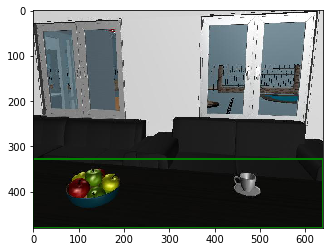

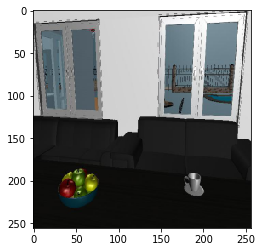

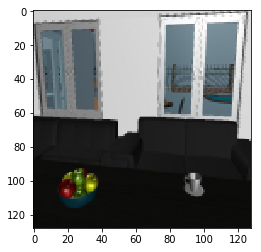

(array([0.56640625, 0.74166667, 0.6265625 , 0.51666667]), 0.0, 'Bed')


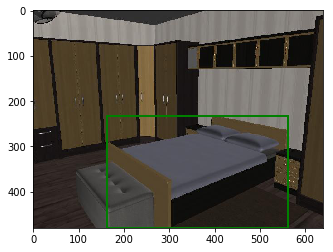

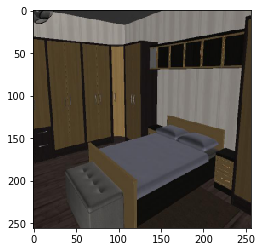

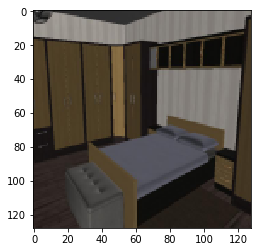

In [123]:
batch_size = 32
image_size = [256, 128]
orig_image_size = [480, 640]
train_proportion = 0.5
statistics = 'basic'
direction_type = 'gt'
data = MLTData(batch_size, image_size, orig_image_size, train_proportion, statistics, direction_type)
im, orig_im, box, direction, label, _ = data.get_next_batch('train')
data.display(im, orig_im, box, direction, label)
im, orig_im, box, direction, label, _ = data.get_next_batch('test')
data.display(im, orig_im, box, direction, label)

number of training image: 10742, number of testing image: 4605
('train', {3: 3396, 4: 5141, 5: 3711, 6: 3380, 13: 2604, 24: 1587}, 0.25939754780765933)
(0.1, 0.9, 0.4997509097961552, 0.5)
(0.13333333333333333, 0.8666666666666667, 0.7326732975091242, 0.7645833333333333)
(0.2, 1.0, 0.4115078176245017, 0.35625)
(0.26666666666666666, 1.0, 0.41066022503658106, 0.39166666666666666)


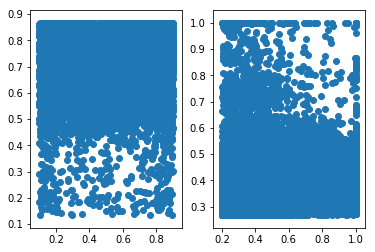

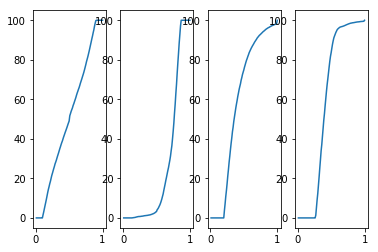

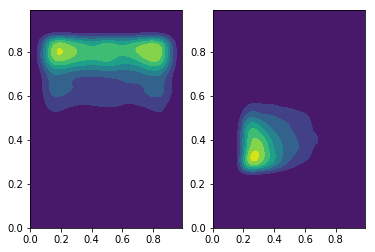

('test', {3: 1515, 4: 2152, 5: 1548, 6: 1383, 13: 1058, 24: 755}, 0.25585542741647843)
(0.1, 0.9, 0.49978190762097247, 0.5)
(0.13333333333333333, 0.8666666666666667, 0.7308772242698055, 0.7614583333333333)
(0.2, 1.0, 0.41143331649031034, 0.35625)
(0.26666666666666666, 1.0, 0.41191297110926167, 0.39375)


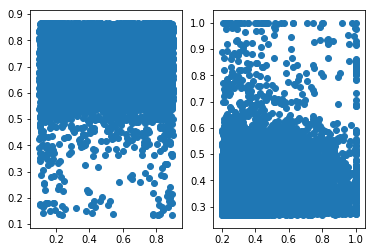

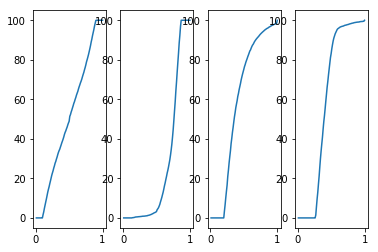

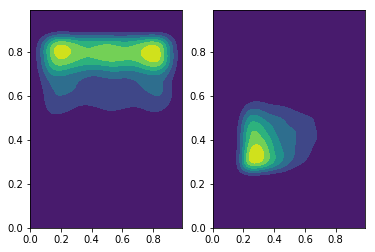

(array([0., 3., 1., 1.]), 2.0, 'Sofa')


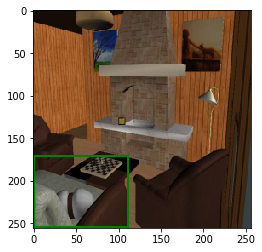

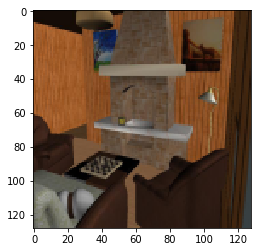

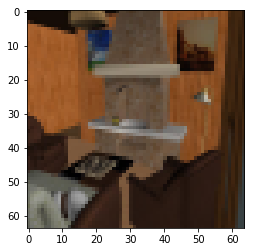

(array([3., 1., 1., 1.]), 4.0, 'Desks')


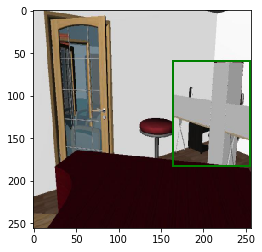

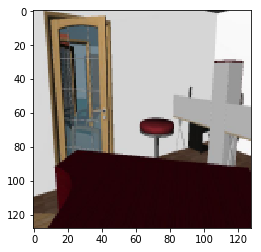

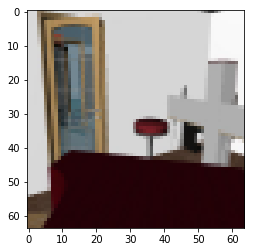

In [124]:
batch_size = 16
image_size = [128, 64]
orig_image_size = [256, 256]
train_proportion = 1
statistics = 'full'
direction_type = 'discrete'
data = MLTData(batch_size, image_size, orig_image_size, train_proportion, statistics, direction_type)
im, orig_im, box, direction, label, _ = data.get_next_batch('train')
data.display(im, orig_im, box, direction, label)
im, orig_im, box, direction, label, _ = data.get_next_batch('test')
data.display(im, orig_im, box, direction, label)

In [125]:
class BaseAttnDemo(object):
    def __init__(self, learning_rate, train_epoch, test_epoch, test_interval, save_interval, save_dir, batch_size, 
                 image_size, orig_image_size, attention_size, image_channel, num_class, tensorboard_path, 
                 init_model_path, train_proportion=1):
        logging.info('Baseline with estimated attention from image only')
        self.learning_rate = learning_rate
        self.train_epoch = train_epoch
        self.test_epoch = test_epoch
        self.test_interval = test_interval
        self.save_interval = save_interval
        self.save_dir = save_dir
        self.best_test_acc = -1e10
        self.batch_size = batch_size
        self.im_size = image_size
        self.orig_im_size = orig_image_size
        self.attn_size = attention_size
        self.im_channel = image_channel
        self.n_class = num_class
        self.tensorboard_path = tensorboard_path
        self.init_model_path = init_model_path
        self.data = MLTData(batch_size, image_size, orig_image_size, train_proportion)
        self.model = self.init_model()

    def init_model(self):
        self.model = BaseAttnNet(self.batch_size, self.im_size, self.attn_size, self.im_channel, self.n_class)
        if torch.cuda.is_available():
            # model = torch.nn.DataParallel(model).cuda()
            self.model = self.model.cuda()
        if self.init_model_path is not '':
            self.model.load_state_dict(torch.load(self.init_model_path))
        return self.model

    def train(self):
        writer = SummaryWriter(self.tensorboard_path)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        train_loss_all, train_acc_all = [], []
        for epoch in range(self.train_epoch):
            optimizer.zero_grad()
            im, orig_im, box, direction, label, _ = self.data.get_next_batch('train')
            im = [Variable(torch.from_numpy(i_s).float()) for i_s in im]
            box = Variable(torch.from_numpy(box).float())
            label = Variable(torch.from_numpy(label).long())
            if torch.cuda.is_available():
                im, box, label = [i_s.cuda() for i_s in im], box.cuda(), label.cuda()
            pred, attn = self.model(im)
            loss = criterion(pred, label)
            loss.backward()
            optimizer.step()

            _, pred_label = torch.max(pred.data, 1)
            acc = (pred_label == label.data).sum() * 1.0 / label.size(0)
            
            writer.add_scalar('train_loss', loss.data[0], epoch)
            train_loss_all.append(loss.data[0])
            if len(train_loss_all) > 100:
                train_loss_all.pop(0)
            ave_train_loss = sum(train_loss_all) / float(len(train_loss_all))
            logging.info('epoch %d, train loss: %.2f, average train loss: %.2f', epoch, loss.data[0], ave_train_loss)
            writer.add_scalar('train_acc', acc, epoch)
            train_acc_all.append(acc)
            if len(train_acc_all) > 100:
                train_acc_all.pop(0)
            ave_train_acc = sum(train_acc_all) / float(len(train_acc_all))
            logging.info('epoch %d, train accuracy: %.2f, average train accuracy: %.2f', epoch, acc, ave_train_acc)
            if (epoch+1) % self.save_interval == 0:
                logging.info('epoch %d, saving model', epoch)
                with open(os.path.join(self.save_dir, '%d.pth' % epoch), 'w') as handle:
                    torch.save(self.model.state_dict(), handle)
            if (epoch+1) % self.test_interval == 0:
                logging.info('epoch %d, testing', epoch)
                test_loss, test_acc = self.validate()
                writer.add_scalar('test_loss', test_loss, epoch)
                writer.add_scalar('test_acc', test_acc, epoch)
        writer.close()

    def validate(self):
        test_loss, test_acc = self.test()
        if test_acc >= self.best_test_acc:
            logging.info('model save to %s', os.path.join(self.save_dir, 'model.pth'))
            with open(os.path.join(self.save_dir, 'model.pth'), 'w') as handle:
                torch.save(self.model.state_dict(), handle)
            self.best_test_acc = test_acc
        logging.info('current best test accuracy: %.2f', self.best_test_acc)
        return test_loss, test_acc

    def test(self):
        test_loss_all, test_acc_all = [], []
        criterion = nn.CrossEntropyLoss()
        for epoch in range(self.test_epoch):
            im, orig_im, box, direction, label, _ = self.data.get_next_batch('test')
            im = [Variable(torch.from_numpy(i_s).float(), volatile=True) for i_s in im]
            box = Variable(torch.from_numpy(box).float(), volatile=True)
            label = Variable(torch.from_numpy(label).long(), volatile=True)
            if torch.cuda.is_available():
                im, box, label = [i_s.cuda() for i_s in im], box.cuda(), label.cuda()
            pred, attn = self.model(im)
            loss = criterion(pred, label)
            _, pred_label = torch.max(pred.data, 1)
            acc = (pred_label == label.data).sum() * 1.0 / label.size(0)

            test_loss_all.append(loss.data[0])
            if len(test_loss_all) > 100:
                test_loss_all.pop(0)
            test_acc_all.append(acc)
            if len(test_acc_all) > 100:
                test_acc_all.pop(0)

        test_loss = np.mean(np.array(test_loss_all))
        test_acc = np.mean(np.array(test_acc_all))
        logging.info('average test loss: %.2f', test_loss)
        logging.info('average test accuracy: %.2f', test_acc)
        return test_loss, test_acc
    
    def test_all(self):
        test_loss_all, test_acc_all = [], []
        criterion = nn.CrossEntropyLoss()
        self.data.test_cnt = 0 # Restart from the first testing batch, note that this is important if you test() before.
        while True:
            im, orig_im, box, direction, label, restart = self.data.get_next_batch('test')
            if restart:
                break
            im = [Variable(torch.from_numpy(i_s).float(), volatile=True) for i_s in im]
            box = Variable(torch.from_numpy(box).float(), volatile=True)
            label = Variable(torch.from_numpy(label).long(), volatile=True)
            if torch.cuda.is_available():
                im, box, label = [i_s.cuda() for i_s in im], box.cuda(), label.cuda()
            pred, attn = self.model(im)
            loss = criterion(pred, label)
            _, pred_label = torch.max(pred.data, 1)
            acc = (pred_label == label.data).sum() * 1.0 / label.size(0)
            test_loss_all.append(loss.data[0])
            test_acc_all.append(acc)

        test_loss = np.mean(np.array(test_loss_all))
        test_acc = np.mean(np.array(test_acc_all))
        logging.info('overall average test loss: %.2f', test_loss)
        logging.info('overall average test accuracy: %.2f', test_acc)
        
    def visualize(self):
        im, orig_im, box, direction, label, _ = self.data.get_next_batch('test')
        im = [Variable(torch.from_numpy(i_s).float(), volatile=True) for i_s in im]
        box = Variable(torch.from_numpy(box).float(), volatile=True)
        label = Variable(torch.from_numpy(label).long(), volatile=True)
        if torch.cuda.is_available():
            im, box, label = [i_s.cuda() for i_s in im], box.cuda(), label.cuda()
        pred, attn = self.model(im)
        self.visualize_groundtruth(orig_im, box, label)
        self.visualize_attn(im, attn, pred)
        
    def visualize_attn(self, images, attn, pred):
        # reconstruct attention maps in multiple scales from a single vector
        attn_maps, cnt = [], 0
        for i in range(len(images)):
            a = attn[:, cnt:cnt + self.attn_size[i]**2]
            a = a.contiguous().view(-1, self.attn_size[i], self.attn_size[i])
            cnt = cnt + self.attn_size[i]**2
            attn_maps.append(a)
        # construct a full image containing all scale images and a full attention map containing all scale attention maps
        max_im_size = np.max(np.array(self.im_size))
        sum_im_size = np.sum(np.array(self.im_size))
        im_all = np.zeros((max_im_size, sum_im_size, 3))
        max_attn_size = np.max(np.array(self.attn_size))
        sum_attn_size = np.sum(np.array(self.attn_size))
        attn_all = np.zeros((max_attn_size, sum_attn_size))
        cnt_im, cnt_attn = 0, 0
        for i in range(len(images)):
            im = images[i].cpu().data.numpy()
            im = im[0, :, :, :].transpose(1, 2, 0)
            height, width = im.shape[0], im.shape[1]
            im_all[0:height, cnt_im:cnt_im + width, :] = im
            cnt_im = cnt_im + width
            
            attn = attn_maps[i].cpu().data.numpy()
            attn = attn[0, :, :]
            height, width = attn.shape[0], attn.shape[1]
            attn_all[0:height, cnt_attn:cnt_attn + width] = attn
            cnt_attn = cnt_attn + width
        
        pred = pred.cpu().data.numpy()
        pred = pred[0, :]
        pred_label = np.argmax(pred)
        print('prediction:', pred, pred_label, self.data.inverse_class_map[pred_label])
        
        fig, ax = plt.subplots(1)
        ax.imshow(im_all)
        fig, ax = plt.subplots(1)
        ax.imshow(attn_all)
        plt.show()
        
    def visualize_groundtruth(self, orig_im, box, label):
        label = label.cpu().data.numpy()
        label = label[0]
        print('groundtruth:', label, self.data.inverse_class_map[label])
        # Plot original large image with bounding box
        orig_im = orig_im[0, :, :, :].transpose(1, 2, 0)
        fig, ax = plt.subplots(1)
        ax.imshow(orig_im)

        box = box.cpu().data.numpy()
        b = box[0, 0:4].copy()
        im_height, im_width = orig_im.shape[0], orig_im.shape[1]
        b[0], b[1], b[2], b[3] = b[0] * im_width, b[1] * im_height, b[2] * im_width, b[3] * im_height
        rect = patches.Rectangle((b[0], b[1]), b[2] - 1 - b[0], b[3] - 1 - b[1], linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)

        plt.show()  

In [126]:
class BaseAttnNet(nn.Module):
    def __init__(self, batch_size, im_size, attn_size, im_channel, n_class):
        super(BaseAttnNet, self).__init__()
        num_hidden = 16
        self.bn0 = nn.BatchNorm2d(im_channel)
        self.conv1 = nn.Conv2d(im_channel, num_hidden, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(num_hidden)
        self.conv2 = nn.Conv2d(num_hidden, num_hidden*2, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(num_hidden*2)
        self.conv3 = nn.Conv2d(num_hidden*2, num_hidden*4, 3, 1, 1)
        self.bn3 = nn.BatchNorm2d(num_hidden*4)
        self.conv4 = nn.Conv2d(num_hidden*4, num_hidden*8, 3, 1, 1)
        self.bn4 = nn.BatchNorm2d(num_hidden*8)
        self.conv5 = nn.Conv2d(num_hidden*8, num_hidden*16, 3, 1, 1)
        self.bn5 = nn.BatchNorm2d(num_hidden*16)
        self.conv6 = nn.Conv2d(num_hidden*16, num_hidden*32, 3, 1, 1)
        self.bn6 = nn.BatchNorm2d(num_hidden*32)
        
        self.conv_i = nn.Conv2d(num_hidden*32, num_hidden*32, 3, 1, 1) # feature for recognition
        self.bn_i = nn.BatchNorm2d(num_hidden*32)
        self.conv_a = nn.Conv2d(num_hidden*32, num_hidden*32, 3, 1, 1) # feature for attention
        self.bn_a = nn.BatchNorm2d(num_hidden*32)
        
        self.conv_attn = nn.Conv2d(num_hidden*32, 1, 1, 1, 0)
        
        self.fc = nn.Linear(num_hidden*32, n_class)

        self.maxpool = nn.MaxPool2d(2, stride=2, return_indices=False, ceil_mode=False)
        
        self.batch_size = batch_size
        self.im_size = im_size
        self.attn_size = attn_size

    def soft_attn(self, attn_feat):
        for i in range(len(attn_feat)):
            attn_feat[i] = self.conv_attn(attn_feat[i])
            attn_feat[i] = attn_feat[i].view(attn_feat[i].size(0), -1)
        x_a = torch.cat(attn_feat, 1)
        attn = F.softmax(x_a, 1)
        return attn

    def attn_pool(self, im_feat, attn):
        for i in range(len(im_feat)):
            im_feat[i] = im_feat[i].view(im_feat[i].size(0), im_feat[i].size(1), -1)
        im_feat = torch.cat(im_feat, 2)
        final_feat = torch.sum(im_feat * attn[:, None, :], 2)
        return final_feat
    
    def forward(self, images):
        im_feat, attn_feat = [], []
        for im in images:
            x = self.bn0(im)
            x1 = F.relu(self.bn1(self.conv1(x)))
            x2 = self.maxpool(x1)
            x2 = F.relu(self.bn2(self.conv2(x2)))
            x3 = self.maxpool(x2)
            x3 = F.relu(self.bn3(self.conv3(x3)))
            x4 = self.maxpool(x3)
            x4 = F.relu(self.bn4(self.conv4(x4)))
            x5 = self.maxpool(x4)
            x5 = F.relu(self.bn5(self.conv5(x5)))
            x6 = self.maxpool(x5)
            x6 = F.relu(self.bn6(self.conv6(x6)))
            x_i = F.relu(self.bn_i(self.conv_i(x6)))
            x_a = F.relu(self.bn_a(self.conv_a(x6)))
            im_feat.append(x_i)
            attn_feat.append(x_a)
        attn = self.soft_attn(attn_feat)
        x = self.attn_pool(im_feat, attn)
        x = x.view(x.size(0), -1)
        pred = self.fc(x)
        return pred, attn

03:10:41 INFO:Baseline with estimated attention from image only


number of training image: 10742, number of testing image: 4605
('train', {3: 3396, 4: 5141, 5: 3711, 6: 3380, 13: 2604, 24: 1587}, 0.25939754780765933)
('test', {3: 1515, 4: 2152, 5: 1548, 6: 1383, 13: 1058, 24: 755}, 0.25585542741647843)


03:10:43 INFO:epoch 0, train loss: 1.84, average train loss: 1.84
03:10:43 INFO:epoch 0, train accuracy: 0.12, average train accuracy: 0.12
03:10:44 INFO:epoch 1, train loss: 1.92, average train loss: 1.88
03:10:44 INFO:epoch 1, train accuracy: 0.11, average train accuracy: 0.12
03:10:45 INFO:epoch 2, train loss: 1.95, average train loss: 1.90
03:10:45 INFO:epoch 2, train accuracy: 0.16, average train accuracy: 0.13
03:10:47 INFO:epoch 3, train loss: 1.72, average train loss: 1.86
03:10:47 INFO:epoch 3, train accuracy: 0.30, average train accuracy: 0.17
03:10:48 INFO:epoch 4, train loss: 1.65, average train loss: 1.82
03:10:48 INFO:epoch 4, train accuracy: 0.33, average train accuracy: 0.20
03:10:49 INFO:epoch 5, train loss: 1.79, average train loss: 1.81
03:10:49 INFO:epoch 5, train accuracy: 0.20, average train accuracy: 0.20
03:10:50 INFO:epoch 6, train loss: 1.85, average train loss: 1.82
03:10:50 INFO:epoch 6, train accuracy: 0.19, average train accuracy: 0.20
03:10:52 INFO:epoch 

('groundtruth:', 0, 'Bed')


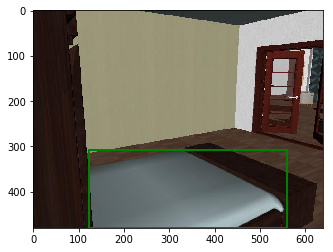

('prediciton:', array([ 3.3646233 , -0.8617412 , -0.8776409 , -0.9360923 ,  0.39422852,
       -0.7950778 ], dtype=float32), 0, 'Bed')


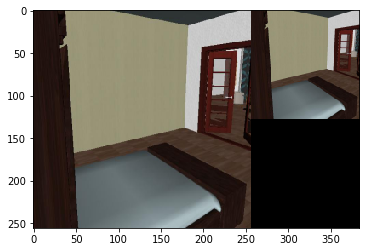

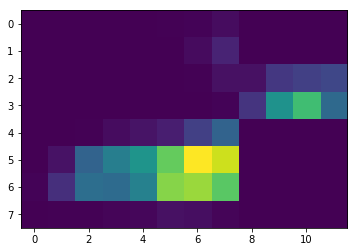

In [115]:
command = 'train'

learning_rate = 1e-3
train_epoch = 1000
test_epoch = 10
test_interval = 100
save_interval = 1001
save_dir = './'
batch_size = 64
im_size = [256, 128]
orig_im_size = [480, 640]
attn_size = [8, 4] 
im_channel = 3
n_class = 6
tensorboard_path = './tensorboard/2d_base_attn_1'
init_model_path = ''
train_proportion = 1
demo = BaseAttnDemo(learning_rate, train_epoch, test_epoch, test_interval, save_interval, save_dir, batch_size, im_size, 
                    orig_im_size, attn_size, im_channel, n_class, tensorboard_path, init_model_path, 
                    train_proportion)
if command == 'train':
    demo.train()
elif command == 'test':
    demo.test()
demo.test_all()
demo.visualize()

('groundtruth:', 1, 'Chair')


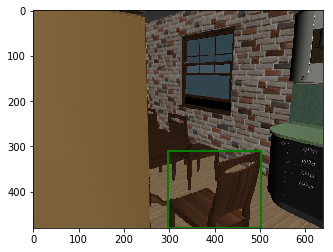

('prediciton:', array([-1.9007385 ,  2.5452917 , -1.1525526 ,  2.1109607 , -0.25826913,
       -2.4827447 ], dtype=float32), 1, 'Chair')


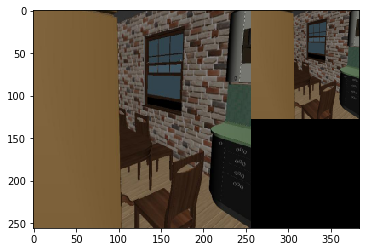

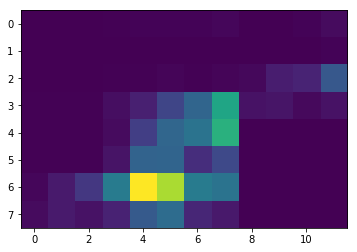

In [119]:
demo.visualize()

In [137]:
class BaseDirectionAttnDemo(object):
    def __init__(self, learning_rate, train_epoch, test_epoch, test_interval, save_interval, save_dir, batch_size, 
                 image_size, orig_image_size, attention_size, image_channel, direction_dim, num_class, tensorboard_path, 
                 init_model_path, train_proportion, statistics, direction_type):
        logging.info('Baseline with estimated attention from keyword only')
        self.learning_rate = learning_rate
        self.train_epoch = train_epoch
        self.test_epoch = test_epoch
        self.test_interval = test_interval
        self.save_interval = save_interval
        self.save_dir = save_dir
        self.best_test_acc = -1e10
        self.batch_size = batch_size
        self.im_size = image_size
        self.orig_im_size = orig_image_size
        self.attn_size = attention_size
        self.im_channel = image_channel
        self.direction_dim = direction_dim
        self.n_class = num_class
        self.tensorboard_path = tensorboard_path
        self.init_model_path = init_model_path
        self.data = MLTData(batch_size, image_size, orig_image_size, train_proportion, statistics, direction_type)
        self.model = self.init_model()

    def init_model(self):
        self.model = BaseDirectionAttnNet(self.batch_size, self.im_size, self.attn_size, self.im_channel, 
                                          self.direction_dim, self.n_class)
        if torch.cuda.is_available():
            # model = torch.nn.DataParallel(model).cuda()
            self.model = self.model.cuda()
        if self.init_model_path is not '':
            self.model.load_state_dict(torch.load(self.init_model_path))
        return self.model

    def train(self):
        writer = SummaryWriter(self.tensorboard_path)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        train_loss_all, train_acc_all = [], []
        for epoch in range(self.train_epoch):
            optimizer.zero_grad()
            im, orig_im, box, direction, label, _ = self.data.get_next_batch('train')
            im = [Variable(torch.from_numpy(i_s).float()) for i_s in im]
            box = Variable(torch.from_numpy(box).float())
            direction = Variable(torch.from_numpy(direction).float())
            label = Variable(torch.from_numpy(label).long())
            if torch.cuda.is_available():
                im, direction, box, label = [i_s.cuda() for i_s in im], direction.cuda(), box.cuda(), label.cuda()
            pred, attn = self.model(im, direction)
            loss = criterion(pred, label)
            loss.backward()
            optimizer.step()

            _, pred_label = torch.max(pred.data, 1)
            acc = (pred_label == label.data).sum() * 1.0 / label.size(0)
            
            writer.add_scalar('train_loss', loss.data[0], epoch)
            train_loss_all.append(loss.data[0])
            if len(train_loss_all) > 100:
                train_loss_all.pop(0)
            ave_train_loss = sum(train_loss_all) / float(len(train_loss_all))
            logging.info('epoch %d, train loss: %.2f, average train loss: %.2f', epoch, loss.data[0], ave_train_loss)
            writer.add_scalar('train_acc', acc, epoch)
            train_acc_all.append(acc)
            if len(train_acc_all) > 100:
                train_acc_all.pop(0)
            ave_train_acc = sum(train_acc_all) / float(len(train_acc_all))
            logging.info('epoch %d, train accuracy: %.2f, average train accuracy: %.2f', epoch, acc, ave_train_acc)
            if (epoch+1) % self.save_interval == 0:
                logging.info('epoch %d, saving model', epoch)
                with open(os.path.join(self.save_dir, '%d.pth' % epoch), 'w') as handle:
                    torch.save(self.model.state_dict(), handle)
            if (epoch+1) % self.test_interval == 0:
                logging.info('epoch %d, testing', epoch)
                test_loss, test_acc = self.validate()
                writer.add_scalar('test_loss', test_loss, epoch)
                writer.add_scalar('test_acc', test_acc, epoch)
        writer.close()

    def validate(self):
        test_loss, test_acc = self.test()
        if test_acc >= self.best_test_acc:
            logging.info('model save to %s', os.path.join(self.save_dir, 'model.pth'))
            with open(os.path.join(self.save_dir, 'model.pth'), 'w') as handle:
                torch.save(self.model.state_dict(), handle)
            self.best_test_acc = test_acc
        logging.info('current best test accuracy: %.2f', self.best_test_acc)
        return test_loss, test_acc

    def test(self):
        test_loss_all, test_acc_all = [], []
        criterion = nn.CrossEntropyLoss()
        for epoch in range(self.test_epoch):
            im, orig_im, box, direction, label, _ = self.data.get_next_batch('test')
            im = [Variable(torch.from_numpy(i_s).float(), volatile=True) for i_s in im]
            box = Variable(torch.from_numpy(box).float(), volatile=True)
            direction = Variable(torch.from_numpy(direction).float(), volatile=True)
            label = Variable(torch.from_numpy(label).long(), volatile=True)
            if torch.cuda.is_available():
                im, direction, box, label = [i_s.cuda() for i_s in im], direction.cuda(), box.cuda(), label.cuda()
            pred, attn = self.model(im, direction)
            loss = criterion(pred, label)
            _, pred_label = torch.max(pred.data, 1)
            acc = (pred_label == label.data).sum() * 1.0 / label.size(0)

            test_loss_all.append(loss.data[0])
            if len(test_loss_all) > 100:
                test_loss_all.pop(0)
            test_acc_all.append(acc)
            if len(test_acc_all) > 100:
                test_acc_all.pop(0)

        test_loss = np.mean(np.array(test_loss_all))
        test_acc = np.mean(np.array(test_acc_all))
        logging.info('average test loss: %.2f', test_loss)
        logging.info('average test accuracy: %.2f', test_acc)
        return test_loss, test_acc
    
    def test_all(self):
        test_loss_all, test_acc_all = [], []
        criterion = nn.CrossEntropyLoss()
        self.data.test_cnt = 0 # Restart from the first testing batch, note that this is important if you test() before.
        while True:
            im, orig_im, box, direction, label, restart = self.data.get_next_batch('test')
            if restart:
                break
            im = [Variable(torch.from_numpy(i_s).float(), volatile=True) for i_s in im]
            box = Variable(torch.from_numpy(box).float(), volatile=True)
            direction = Variable(torch.from_numpy(direction).float(), volatile=True)
            label = Variable(torch.from_numpy(label).long(), volatile=True)
            if torch.cuda.is_available():
                im, direction, box, label = [i_s.cuda() for i_s in im], direction.cuda(), box.cuda(), label.cuda()
            pred, attn = self.model(im, direction)
            loss = criterion(pred, label)
            _, pred_label = torch.max(pred.data, 1)
            acc = (pred_label == label.data).sum() * 1.0 / label.size(0)
            test_loss_all.append(loss.data[0])
            test_acc_all.append(acc)

        test_loss = np.mean(np.array(test_loss_all))
        test_acc = np.mean(np.array(test_acc_all))
        logging.info('overall average test loss: %.2f', test_loss)
        logging.info('overall average test accuracy: %.2f', test_acc)
        
    def visualize(self):
        im, orig_im, box, direction, label, _ = self.data.get_next_batch('test')
        im = [Variable(torch.from_numpy(i_s).float(), volatile=True) for i_s in im]
        box = Variable(torch.from_numpy(box).float(), volatile=True)
        direction = Variable(torch.from_numpy(direction).float(), volatile=True)
        label = Variable(torch.from_numpy(label).long(), volatile=True)
        if torch.cuda.is_available():
            im, direction, box, label = [i_s.cuda() for i_s in im], direction.cuda(), box.cuda(), label.cuda()
        pred, attn = self.model(im, direction)
        self.visualize_groundtruth(orig_im, box, direction, label)
        self.visualize_attn(im, attn, pred)
        
    def visualize_attn(self, images, attn, pred):
        # reconstruct attention maps in multiple scales from a single vector
        attn_maps, cnt = [], 0
        for i in range(len(images)):
            a = attn[:, cnt:cnt + self.attn_size[i]**2]
            a = a.contiguous().view(-1, self.attn_size[i], self.attn_size[i])
            cnt = cnt + self.attn_size[i]**2
            attn_maps.append(a)
        # construct a full image containing all scale images and a full attention map containing all scale attention maps
        max_im_size = np.max(np.array(self.im_size))
        sum_im_size = np.sum(np.array(self.im_size))
        im_all = np.zeros((max_im_size, sum_im_size, 3))
        max_attn_size = np.max(np.array(self.attn_size))
        sum_attn_size = np.sum(np.array(self.attn_size))
        attn_all = np.zeros((max_attn_size, sum_attn_size))
        cnt_im, cnt_attn = 0, 0
        for i in range(len(images)):
            im = images[i].cpu().data.numpy()
            im = im[0, :, :, :].transpose(1, 2, 0)
            height, width = im.shape[0], im.shape[1]
            im_all[0:height, cnt_im:cnt_im + width, :] = im
            cnt_im = cnt_im + width
            
            attn = attn_maps[i].cpu().data.numpy()
            attn = attn[0, :, :]
            height, width = attn.shape[0], attn.shape[1]
            attn_all[0:height, cnt_attn:cnt_attn + width] = attn
            cnt_attn = cnt_attn + width
        
        pred = pred.cpu().data.numpy()
        pred = pred[0, :]
        pred_label = np.argmax(pred)
        print('prediction:', pred, pred_label, self.data.inverse_class_map[pred_label])
        
        fig, ax = plt.subplots(1)
        ax.imshow(im_all)
        fig, ax = plt.subplots(1)
        ax.imshow(attn_all)
        plt.show()
        
    def visualize_groundtruth(self, orig_im, box, direction, label):
        direction = direction.cpu().data.numpy()
        direction = direction[0, :]
        label = label.cpu().data.numpy()
        label = label[0]
        print('groundtruth:', direction, label, self.data.inverse_class_map[label])
        # Plot original large image with bounding box
        orig_im = orig_im[0, :, :, :].transpose(1, 2, 0)
        fig, ax = plt.subplots(1)
        ax.imshow(orig_im)

        box = box.cpu().data.numpy()
        b = box[0, 0:4].copy()
        im_height, im_width = orig_im.shape[0], orig_im.shape[1]
        b[0], b[1], b[2], b[3] = b[0] * im_width, b[1] * im_height, b[2] * im_width, b[3] * im_height
        rect = patches.Rectangle((b[0], b[1]), b[2] - 1 - b[0], b[3] - 1 - b[1], linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)

        plt.show()  

In [138]:
class BaseDirectionAttnNet(nn.Module):
    def __init__(self, batch_size, im_size, attn_size, im_channel, direction_dim, n_class):
        super(BaseDirectionAttnNet, self).__init__()
        num_hidden = 16
        self.bn0 = nn.BatchNorm2d(im_channel)
        self.conv1 = nn.Conv2d(im_channel, num_hidden, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(num_hidden)
        self.conv2 = nn.Conv2d(num_hidden, num_hidden*2, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(num_hidden*2)
        self.conv3 = nn.Conv2d(num_hidden*2, num_hidden*4, 3, 1, 1)
        self.bn3 = nn.BatchNorm2d(num_hidden*4)
        self.conv4 = nn.Conv2d(num_hidden*4, num_hidden*8, 3, 1, 1)
        self.bn4 = nn.BatchNorm2d(num_hidden*8)
        self.conv5 = nn.Conv2d(num_hidden*8, num_hidden*16, 3, 1, 1)
        self.bn5 = nn.BatchNorm2d(num_hidden*16)
        self.conv6 = nn.Conv2d(num_hidden*16, num_hidden*32, 3, 1, 1)
        self.bn6 = nn.BatchNorm2d(num_hidden*32)
        
        self.conv_i = nn.Conv2d(num_hidden*32, num_hidden*32, 3, 1, 1) # feature for recognition
        self.bn_i = nn.BatchNorm2d(num_hidden*32)
        self.conv_a = nn.Conv2d(num_hidden*32, num_hidden*32, 3, 1, 1) # feature for attention
        self.bn_a = nn.BatchNorm2d(num_hidden*32)
        
        self.conv_attn = nn.Conv2d(num_hidden*32, 1, 1, 1, 0)
        
        self.bn_d0 = nn.BatchNorm1d(direction_dim)
        self.fc_d = nn.Linear(direction_dim, num_hidden)
        self.bn_d = nn.BatchNorm1d(num_hidden)
        self.fc_attn = nn.Linear(num_hidden, np.sum(np.array(attn_size)**2))
        
        self.fc = nn.Linear(num_hidden*32, n_class)

        self.maxpool = nn.MaxPool2d(2, stride=2, return_indices=False, ceil_mode=False)
        
        self.batch_size = batch_size
        self.im_size = im_size
        self.attn_size = attn_size
        
    def soft_attn(self, direction):
        d0 = self.bn_d0(direction)
        d = F.relu(self.bn_d(self.fc_d(d0)))
        x_d = self.fc_attn(d)
        # x_d = self.fc_attn(direction)
        attn = F.softmax(x_d, 1)
        return attn
        
    def attn_pool(self, im_feat, attn):
        for i in range(len(im_feat)):
            im_feat[i] = im_feat[i].view(im_feat[i].size(0), im_feat[i].size(1), -1)
        im_feat = torch.cat(im_feat, 2)
        final_feat = torch.sum(im_feat * attn[:, None, :], 2)
        return final_feat
        
    def forward(self, images, direction):
        im_feat, attn_feat = [], []
        for im in images:
            x = self.bn0(im)
            x1 = F.relu(self.bn1(self.conv1(x)))
            x2 = self.maxpool(x1)
            x2 = F.relu(self.bn2(self.conv2(x2)))
            x3 = self.maxpool(x2)
            x3 = F.relu(self.bn3(self.conv3(x3)))
            x4 = self.maxpool(x3)
            x4 = F.relu(self.bn4(self.conv4(x4)))
            x5 = self.maxpool(x4)
            x5 = F.relu(self.bn5(self.conv5(x5)))
            x6 = self.maxpool(x5)
            x6 = F.relu(self.bn6(self.conv6(x6)))
            x_i = F.relu(self.bn_i(self.conv_i(x6)))
            x_a = F.relu(self.bn_a(self.conv_a(x6)))
            im_feat.append(x_i)
            attn_feat.append(x_a)
        attn = self.soft_attn(direction)
        x = self.attn_pool(im_feat, attn)
        x = x.view(x.size(0), -1)
        pred = self.fc(x)
        return pred, attn

03:55:05 INFO:Baseline with estimated attention from keyword only


number of training image: 10742, number of testing image: 4605
('train', {3: 3396, 4: 5141, 5: 3711, 6: 3380, 13: 2604, 24: 1587}, 0.25939754780765933)
('test', {3: 1515, 4: 2152, 5: 1548, 6: 1383, 13: 1058, 24: 755}, 0.25585542741647843)


03:55:06 INFO:epoch 0, train loss: 1.78, average train loss: 1.78
03:55:06 INFO:epoch 0, train accuracy: 0.16, average train accuracy: 0.16
03:55:08 INFO:epoch 1, train loss: 1.88, average train loss: 1.83
03:55:08 INFO:epoch 1, train accuracy: 0.25, average train accuracy: 0.20
03:55:09 INFO:epoch 2, train loss: 1.98, average train loss: 1.88
03:55:09 INFO:epoch 2, train accuracy: 0.14, average train accuracy: 0.18
03:55:10 INFO:epoch 3, train loss: 1.72, average train loss: 1.84
03:55:10 INFO:epoch 3, train accuracy: 0.27, average train accuracy: 0.20
03:55:11 INFO:epoch 4, train loss: 1.83, average train loss: 1.84
03:55:11 INFO:epoch 4, train accuracy: 0.22, average train accuracy: 0.21
03:55:12 INFO:epoch 5, train loss: 1.78, average train loss: 1.83
03:55:12 INFO:epoch 5, train accuracy: 0.17, average train accuracy: 0.20
03:55:14 INFO:epoch 6, train loss: 1.77, average train loss: 1.82
03:55:14 INFO:epoch 6, train accuracy: 0.28, average train accuracy: 0.21
03:55:15 INFO:epoch 

('groundtruth:', array([0.71015626, 0.67604166, 0.3359375 , 0.43958333], dtype=float32), 2, 'Sofa')


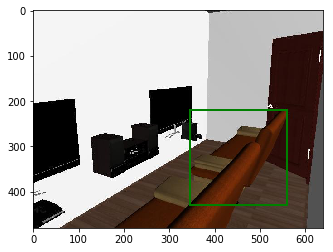

('prediction:', array([-1.3176496 ,  0.51949215, -0.1931238 , -2.2652261 ,  0.6095906 ,
       -0.0796105 ], dtype=float32), 4, 'Desks')


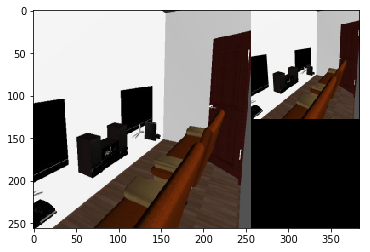

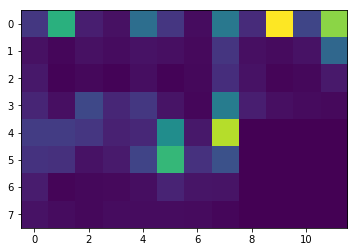

In [140]:
command = 'train'

learning_rate = 1e-3
train_epoch = 1000
test_epoch = 10
test_interval = 100
save_interval = 1001
save_dir = './'
batch_size = 64
im_size = [256, 128]
orig_im_size = [480, 640]
attn_size = [8, 4] 
im_channel = 3
direction_dim = 4
n_class = 6
tensorboard_path = './tensorboard/2d_base_gt_direction_attn_1'
init_model_path = ''
train_proportion = 1
statistics = 'basic'
direction_type = 'gt'
demo = BaseDirectionAttnDemo(learning_rate, train_epoch, test_epoch, test_interval, save_interval, save_dir, batch_size, 
                             im_size, orig_im_size, attn_size, im_channel, direction_dim, n_class, tensorboard_path, 
                             init_model_path, train_proportion, statistics, direction_type)
if command == 'train':
    demo.train()
elif command == 'test':
    demo.test()
demo.test_all()
demo.visualize()

('groundtruth:', array([0.7867187 , 0.71770835, 0.4015625 , 0.48958334], dtype=float32), 5, 'Television')


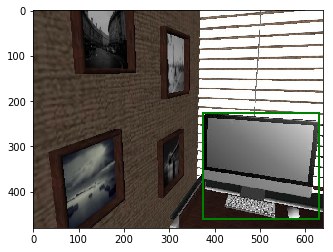

('prediction:', array([-1.7579167,  0.6777928, -1.1049541, -1.1149589,  0.2566311,
        0.8051676], dtype=float32), 5, 'Television')


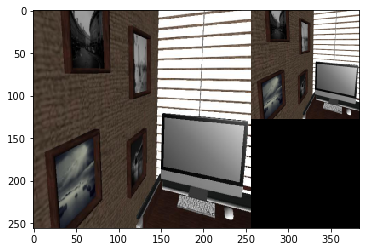

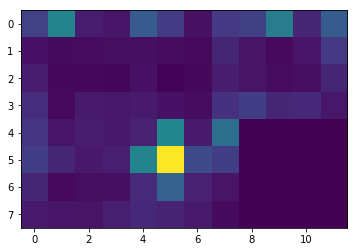

In [144]:
demo.visualize()

04:21:52 INFO:Baseline with estimated attention from keyword only


number of training image: 10742, number of testing image: 4605
('train', {3: 3396, 4: 5141, 5: 3711, 6: 3380, 13: 2604, 24: 1587}, 0.25939754780765933)
('test', {3: 1515, 4: 2152, 5: 1548, 6: 1383, 13: 1058, 24: 755}, 0.25585542741647843)


04:21:54 INFO:epoch 0, train loss: 1.82, average train loss: 1.82
04:21:54 INFO:epoch 0, train accuracy: 0.12, average train accuracy: 0.12
04:21:55 INFO:epoch 1, train loss: 1.83, average train loss: 1.83
04:21:55 INFO:epoch 1, train accuracy: 0.28, average train accuracy: 0.20
04:21:56 INFO:epoch 2, train loss: 1.79, average train loss: 1.81
04:21:56 INFO:epoch 2, train accuracy: 0.20, average train accuracy: 0.20
04:21:58 INFO:epoch 3, train loss: 2.07, average train loss: 1.88
04:21:58 INFO:epoch 3, train accuracy: 0.14, average train accuracy: 0.19
04:21:59 INFO:epoch 4, train loss: 1.82, average train loss: 1.87
04:21:59 INFO:epoch 4, train accuracy: 0.22, average train accuracy: 0.19
04:22:00 INFO:epoch 5, train loss: 1.73, average train loss: 1.84
04:22:00 INFO:epoch 5, train accuracy: 0.28, average train accuracy: 0.21
04:22:01 INFO:epoch 6, train loss: 1.83, average train loss: 1.84
04:22:01 INFO:epoch 6, train accuracy: 0.25, average train accuracy: 0.21
04:22:03 INFO:epoch 

('groundtruth:', array([3., 2., 1., 1.], dtype=float32), 2, 'Sofa')


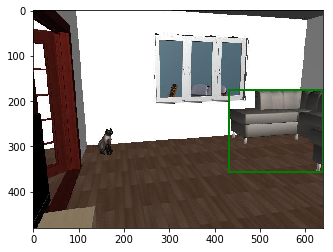

('prediction:', array([-0.91505486, -1.0226027 ,  3.6753526 ,  1.4079077 , -3.4197307 ,
       -4.5266905 ], dtype=float32), 2, 'Sofa')


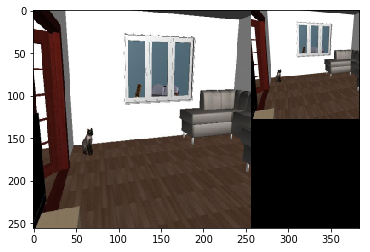

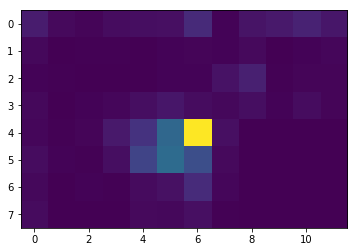

In [145]:
command = 'train'

learning_rate = 1e-3
train_epoch = 1000
test_epoch = 10
test_interval = 100
save_interval = 1001
save_dir = './'
batch_size = 64
im_size = [256, 128]
orig_im_size = [480, 640]
attn_size = [8, 4] 
im_channel = 3
direction_dim = 4
n_class = 6
tensorboard_path = './tensorboard/2d_base_direction_attn_1'
init_model_path = ''
train_proportion = 1
statistics = 'basic'
direction_type = 'discrete'
demo = BaseDirectionAttnDemo(learning_rate, train_epoch, test_epoch, test_interval, save_interval, save_dir, batch_size, 
                             im_size, orig_im_size, attn_size, im_channel, direction_dim, n_class, tensorboard_path, 
                             init_model_path, train_proportion, statistics, direction_type)
if command == 'train':
    demo.train()
elif command == 'test':
    demo.test()
demo.test_all()
demo.visualize()

('groundtruth:', array([1., 2., 1., 2.], dtype=float32), 5, 'Television')


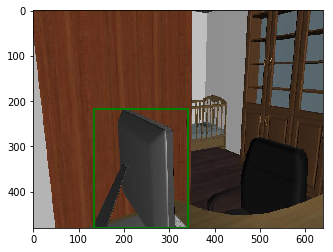

('prediction:', array([ 0.07123996,  0.00997951, -0.68412507,  0.5300069 , -0.28703612,
       -1.4076499 ], dtype=float32), 3, 'Table')


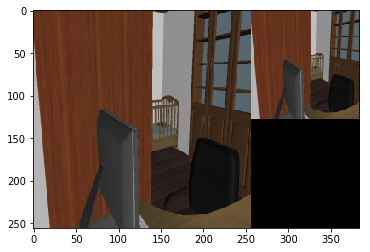

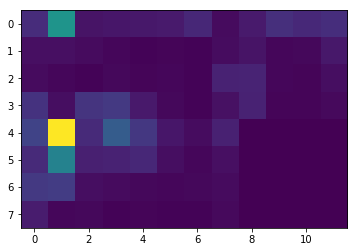

In [147]:
demo.visualize()

In [148]:
class BaseDirectionAttnCombDemo(object):
    def __init__(self, learning_rate, train_epoch, test_epoch, test_interval, save_interval, save_dir, batch_size, 
                 image_size, orig_image_size, attention_size, image_channel, direction_dim, num_class, tensorboard_path, 
                 init_model_path, train_proportion, statistics, direction_type):
        logging.info('Baseline with bounding box crop estimated from both image and keyword')
        self.learning_rate = learning_rate
        self.train_epoch = train_epoch
        self.test_epoch = test_epoch
        self.test_interval = test_interval
        self.save_interval = save_interval
        self.save_dir = save_dir
        self.best_test_acc = -1e10
        self.batch_size = batch_size
        self.im_size = image_size
        self.orig_im_size = orig_image_size
        self.attn_size = attention_size
        self.im_channel = image_channel
        self.direction_dim = direction_dim
        self.n_class = num_class
        self.tensorboard_path = tensorboard_path
        self.init_model_path = init_model_path
        self.data = MLTData(batch_size, image_size, orig_image_size, train_proportion, statistics, direction_type)
        self.model = self.init_model()

    def init_model(self):
        self.model = BaseDirectionAttnCombNet(self.batch_size, self.im_size, self.attn_size, self.im_channel, 
                                              self.direction_dim, self.n_class)
        if torch.cuda.is_available():
            # model = torch.nn.DataParallel(model).cuda()
            self.model = self.model.cuda()
        if self.init_model_path is not '':
            self.model.load_state_dict(torch.load(self.init_model_path))
        return self.model

    def train(self):
        writer = SummaryWriter(self.tensorboard_path)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        train_loss_all, train_acc_all = [], []
        for epoch in range(self.train_epoch):
            optimizer.zero_grad()
            im, orig_im, box, direction, label, _ = self.data.get_next_batch('train')
            im = [Variable(torch.from_numpy(i_s).float()) for i_s in im]
            box = Variable(torch.from_numpy(box).float())
            direction = Variable(torch.from_numpy(direction).float())
            label = Variable(torch.from_numpy(label).long())
            if torch.cuda.is_available():
                im, direction, box, label = [i_s.cuda() for i_s in im], direction.cuda(), box.cuda(), label.cuda()
            pred, attn = self.model(im, direction)
            loss = criterion(pred, label)
            loss.backward()
            optimizer.step()

            _, pred_label = torch.max(pred.data, 1)
            acc = (pred_label == label.data).sum() * 1.0 / label.size(0)
            
            writer.add_scalar('train_loss', loss.data[0], epoch)
            train_loss_all.append(loss.data[0])
            if len(train_loss_all) > 100:
                train_loss_all.pop(0)
            ave_train_loss = sum(train_loss_all) / float(len(train_loss_all))
            logging.info('epoch %d, train loss: %.2f, average train loss: %.2f', epoch, loss.data[0], ave_train_loss)
            writer.add_scalar('train_acc', acc, epoch)
            train_acc_all.append(acc)
            if len(train_acc_all) > 100:
                train_acc_all.pop(0)
            ave_train_acc = sum(train_acc_all) / float(len(train_acc_all))
            logging.info('epoch %d, train accuracy: %.2f, average train accuracy: %.2f', epoch, acc, ave_train_acc)
            if (epoch+1) % self.save_interval == 0:
                logging.info('epoch %d, saving model', epoch)
                with open(os.path.join(self.save_dir, '%d.pth' % epoch), 'w') as handle:
                    torch.save(self.model.state_dict(), handle)
            if (epoch+1) % self.test_interval == 0:
                logging.info('epoch %d, testing', epoch)
                test_loss, test_acc = self.validate()
                writer.add_scalar('test_loss', test_loss, epoch)
                writer.add_scalar('test_acc', test_acc, epoch)
        writer.close()

    def validate(self):
        test_loss, test_acc = self.test()
        if test_acc >= self.best_test_acc:
            logging.info('model save to %s', os.path.join(self.save_dir, 'model.pth'))
            with open(os.path.join(self.save_dir, 'model.pth'), 'w') as handle:
                torch.save(self.model.state_dict(), handle)
            self.best_test_acc = test_acc
        logging.info('current best test accuracy: %.2f', self.best_test_acc)
        return test_loss, test_acc

    def test(self):
        test_loss_all, test_acc_all = [], []
        criterion = nn.CrossEntropyLoss()
        for epoch in range(self.test_epoch):
            im, orig_im, box, direction, label, _ = self.data.get_next_batch('test')
            im = [Variable(torch.from_numpy(i_s).float(), volatile=True) for i_s in im]
            box = Variable(torch.from_numpy(box).float(), volatile=True)
            direction = Variable(torch.from_numpy(direction).float(), volatile=True)
            label = Variable(torch.from_numpy(label).long(), volatile=True)
            if torch.cuda.is_available():
                im, direction, box, label = [i_s.cuda() for i_s in im], direction.cuda(), box.cuda(), label.cuda()
            pred, attn = self.model(im, direction)
            loss = criterion(pred, label)
            _, pred_label = torch.max(pred.data, 1)
            acc = (pred_label == label.data).sum() * 1.0 / label.size(0)

            test_loss_all.append(loss.data[0])
            if len(test_loss_all) > 100:
                test_loss_all.pop(0)
            test_acc_all.append(acc)
            if len(test_acc_all) > 100:
                test_acc_all.pop(0)

        test_loss = np.mean(np.array(test_loss_all))
        test_acc = np.mean(np.array(test_acc_all))
        logging.info('average test loss: %.2f', test_loss)
        logging.info('average test accuracy: %.2f', test_acc)
        return test_loss, test_acc
    
    def test_all(self):
        test_loss_all, test_acc_all = [], []
        criterion = nn.CrossEntropyLoss()
        self.data.test_cnt = 0 # Restart from the first testing batch, note that this is important if you test() before.
        while True:
            im, orig_im, box, direction, label, restart = self.data.get_next_batch('test')
            if restart:
                break
            im = [Variable(torch.from_numpy(i_s).float(), volatile=True) for i_s in im]
            box = Variable(torch.from_numpy(box).float(), volatile=True)
            direction = Variable(torch.from_numpy(direction).float(), volatile=True)
            label = Variable(torch.from_numpy(label).long(), volatile=True)
            if torch.cuda.is_available():
                im, direction, box, label = [i_s.cuda() for i_s in im], direction.cuda(), box.cuda(), label.cuda()
            pred, attn = self.model(im, direction)
            loss = criterion(pred, label)
            _, pred_label = torch.max(pred.data, 1)
            acc = (pred_label == label.data).sum() * 1.0 / label.size(0)
            test_loss_all.append(loss.data[0])
            test_acc_all.append(acc)

        test_loss = np.mean(np.array(test_loss_all))
        test_acc = np.mean(np.array(test_acc_all))
        logging.info('overall average test loss: %.2f', test_loss)
        logging.info('overall average test accuracy: %.2f', test_acc)
        
    def visualize(self):
        im, orig_im, box, direction, label, _ = self.data.get_next_batch('test')
        im = [Variable(torch.from_numpy(i_s).float(), volatile=True) for i_s in im]
        box = Variable(torch.from_numpy(box).float(), volatile=True)
        direction = Variable(torch.from_numpy(direction).float(), volatile=True)
        label = Variable(torch.from_numpy(label).long(), volatile=True)
        if torch.cuda.is_available():
            im, direction, box, label = [i_s.cuda() for i_s in im], direction.cuda(), box.cuda(), label.cuda()
        pred, attn = self.model(im, direction)
        self.visualize_groundtruth(orig_im, box, direction, label)
        self.visualize_attn(im, attn, pred)
        
    def visualize_attn(self, images, attn, pred):
        # reconstruct attention maps in multiple scales from a single vector
        attn_maps, cnt = [], 0
        for i in range(len(images)):
            a = attn[:, cnt:cnt + self.attn_size[i]**2]
            a = a.contiguous().view(-1, self.attn_size[i], self.attn_size[i])
            cnt = cnt + self.attn_size[i]**2
            attn_maps.append(a)
        # construct a full image containing all scale images and a full attention map containing all scale attention maps
        max_im_size = np.max(np.array(self.im_size))
        sum_im_size = np.sum(np.array(self.im_size))
        im_all = np.zeros((max_im_size, sum_im_size, 3))
        max_attn_size = np.max(np.array(self.attn_size))
        sum_attn_size = np.sum(np.array(self.attn_size))
        attn_all = np.zeros((max_attn_size, sum_attn_size))
        cnt_im, cnt_attn = 0, 0
        for i in range(len(images)):
            im = images[i].cpu().data.numpy()
            im = im[0, :, :, :].transpose(1, 2, 0)
            height, width = im.shape[0], im.shape[1]
            im_all[0:height, cnt_im:cnt_im + width, :] = im
            cnt_im = cnt_im + width
            
            attn = attn_maps[i].cpu().data.numpy()
            attn = attn[0, :, :]
            height, width = attn.shape[0], attn.shape[1]
            attn_all[0:height, cnt_attn:cnt_attn + width] = attn
            cnt_attn = cnt_attn + width
        
        pred = pred.cpu().data.numpy()
        pred = pred[0, :]
        pred_label = np.argmax(pred)
        print('prediction:', pred, pred_label, self.data.inverse_class_map[pred_label])
        
        fig, ax = plt.subplots(1)
        ax.imshow(im_all)
        fig, ax = plt.subplots(1)
        ax.imshow(attn_all)
        plt.show()
        
    def visualize_groundtruth(self, orig_im, box, direction, label):
        direction = direction.cpu().data.numpy()
        direction = direction[0, :]
        label = label.cpu().data.numpy()
        label = label[0]
        print('groundtruth:', direction, label, self.data.inverse_class_map[label])
        # Plot original large image with bounding box
        orig_im = orig_im[0, :, :, :].transpose(1, 2, 0)
        fig, ax = plt.subplots(1)
        ax.imshow(orig_im)

        box = box.cpu().data.numpy()
        b = box[0, 0:4].copy()
        im_height, im_width = orig_im.shape[0], orig_im.shape[1]
        b[0], b[1], b[2], b[3] = b[0] * im_width, b[1] * im_height, b[2] * im_width, b[3] * im_height
        rect = patches.Rectangle((b[0], b[1]), b[2] - 1 - b[0], b[3] - 1 - b[1], linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)

        plt.show()

In [149]:
class BaseDirectionAttnCombNet(nn.Module):
    def __init__(self, batch_size, im_size, attn_size, im_channel, direction_dim, n_class):
        super(BaseDirectionAttnCombNet, self).__init__()
        num_hidden = 16
        self.bn0 = nn.BatchNorm2d(im_channel)
        self.conv1 = nn.Conv2d(im_channel, num_hidden, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(num_hidden)
        self.conv2 = nn.Conv2d(num_hidden, num_hidden*2, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(num_hidden*2)
        self.conv3 = nn.Conv2d(num_hidden*2, num_hidden*4, 3, 1, 1)
        self.bn3 = nn.BatchNorm2d(num_hidden*4)
        self.conv4 = nn.Conv2d(num_hidden*4, num_hidden*8, 3, 1, 1)
        self.bn4 = nn.BatchNorm2d(num_hidden*8)
        self.conv5 = nn.Conv2d(num_hidden*8, num_hidden*16, 3, 1, 1)
        self.bn5 = nn.BatchNorm2d(num_hidden*16)
        self.conv6 = nn.Conv2d(num_hidden*16, num_hidden*32, 3, 1, 1)
        self.bn6 = nn.BatchNorm2d(num_hidden*32)
        
        self.conv_i = nn.Conv2d(num_hidden*32, num_hidden*32, 3, 1, 1) # feature for recognition
        self.bn_i = nn.BatchNorm2d(num_hidden*32)
        self.conv_a = nn.Conv2d(num_hidden*32, num_hidden*32, 3, 1, 1) # feature for attention
        self.bn_a = nn.BatchNorm2d(num_hidden*32)
        
        self.conv_attn = nn.Conv2d(num_hidden*32, 1, 1, 1, 0)
        
        self.bn_d0 = nn.BatchNorm1d(direction_dim)
        self.fc_d = nn.Linear(direction_dim, num_hidden)
        self.bn_d = nn.BatchNorm1d(num_hidden)
        self.fc_attn = nn.Linear(num_hidden, np.sum(np.array(attn_size)**2))
        
        self.fc = nn.Linear(num_hidden*32, n_class)

        self.maxpool = nn.MaxPool2d(2, stride=2, return_indices=False, ceil_mode=False)
        
        self.batch_size = batch_size
        self.im_size = im_size
        self.attn_size = attn_size
        
    def soft_attn(self, attn_feat, direction):
        for i in range(len(attn_feat)):
            attn_feat[i] = self.conv_attn(attn_feat[i])
            attn_feat[i] = attn_feat[i].view(attn_feat[i].size(0), -1)
        x_a = torch.cat(attn_feat, 1)
        
        d0 = self.bn_d0(direction)
        d = F.relu(self.bn_d(self.fc_d(d0)))
        x_d = self.fc_attn(d)
        # x_d = self.fc_attn(direction)
        attn = F.softmax((x_a + x_d) / 2, 1)
        return attn
        
    def attn_pool(self, im_feat, attn):
        for i in range(len(im_feat)):
            im_feat[i] = im_feat[i].view(im_feat[i].size(0), im_feat[i].size(1), -1)
        im_feat = torch.cat(im_feat, 2)
        final_feat = torch.sum(im_feat * attn[:, None, :], 2)
        return final_feat
        
    def forward(self, images, direction):
        im_feat, attn_feat = [], []
        for im in images:
            x = self.bn0(im)
            x1 = F.relu(self.bn1(self.conv1(x)))
            x2 = self.maxpool(x1)
            x2 = F.relu(self.bn2(self.conv2(x2)))
            x3 = self.maxpool(x2)
            x3 = F.relu(self.bn3(self.conv3(x3)))
            x4 = self.maxpool(x3)
            x4 = F.relu(self.bn4(self.conv4(x4)))
            x5 = self.maxpool(x4)
            x5 = F.relu(self.bn5(self.conv5(x5)))
            x6 = self.maxpool(x5)
            x6 = F.relu(self.bn6(self.conv6(x6)))
            x_i = F.relu(self.bn_i(self.conv_i(x6)))
            x_a = F.relu(self.bn_a(self.conv_a(x6)))
            im_feat.append(x_i)
            attn_feat.append(x_a)
        attn = self.soft_attn(attn_feat, direction)
        x = self.attn_pool(im_feat, attn)
        x = x.view(x.size(0), -1)
        pred = self.fc(x)
        return pred, attn

04:48:37 INFO:Baseline with bounding box crop estimated from both image and keyword


number of training image: 10742, number of testing image: 4605
('train', {3: 3396, 4: 5141, 5: 3711, 6: 3380, 13: 2604, 24: 1587}, 0.25939754780765933)
('test', {3: 1515, 4: 2152, 5: 1548, 6: 1383, 13: 1058, 24: 755}, 0.25585542741647843)


04:48:39 INFO:epoch 0, train loss: 1.80, average train loss: 1.80
04:48:39 INFO:epoch 0, train accuracy: 0.09, average train accuracy: 0.09
04:48:40 INFO:epoch 1, train loss: 1.79, average train loss: 1.79
04:48:40 INFO:epoch 1, train accuracy: 0.23, average train accuracy: 0.16
04:48:41 INFO:epoch 2, train loss: 2.06, average train loss: 1.88
04:48:41 INFO:epoch 2, train accuracy: 0.23, average train accuracy: 0.19
04:48:42 INFO:epoch 3, train loss: 1.81, average train loss: 1.86
04:48:42 INFO:epoch 3, train accuracy: 0.31, average train accuracy: 0.22
04:48:44 INFO:epoch 4, train loss: 1.74, average train loss: 1.84
04:48:44 INFO:epoch 4, train accuracy: 0.30, average train accuracy: 0.23
04:48:45 INFO:epoch 5, train loss: 1.71, average train loss: 1.82
04:48:45 INFO:epoch 5, train accuracy: 0.34, average train accuracy: 0.25
04:48:46 INFO:epoch 6, train loss: 1.64, average train loss: 1.79
04:48:46 INFO:epoch 6, train accuracy: 0.30, average train accuracy: 0.26
04:48:47 INFO:epoch 

('groundtruth:', array([0.5671875, 0.828125 , 0.640625 , 0.34375  ], dtype=float32), 3, 'Table')


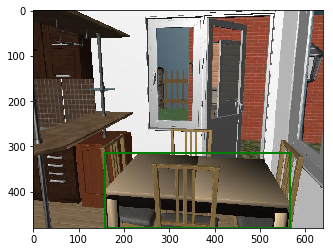

('prediction:', array([-1.4939483,  0.8081679, -1.8194649,  1.955751 ,  2.026053 ,
       -6.0317917], dtype=float32), 4, 'Desks')


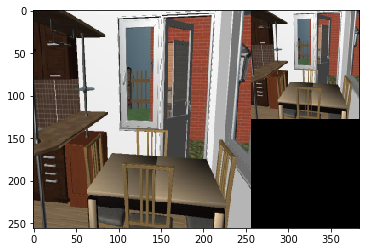

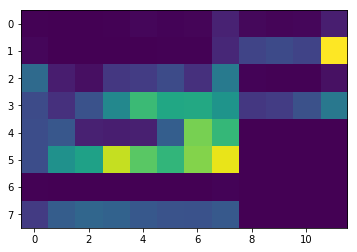

In [150]:
command = 'train'

learning_rate = 1e-3
train_epoch = 1000
test_epoch = 10
test_interval = 100
save_interval = 1001
save_dir = './'
batch_size = 64
im_size = [256, 128]
orig_im_size = [480, 640]
attn_size = [8, 4] 
im_channel = 3
direction_dim = 4
n_class = 6
tensorboard_path = './tensorboard/2d_base_gt_direction_attn_comb_1'
init_model_path = ''
train_proportion = 1
statistics = 'basic'
direction_type = 'gt'
demo = BaseDirectionAttnCombDemo(learning_rate, train_epoch, test_epoch, test_interval, save_interval, save_dir, 
                                 batch_size, im_size, orig_im_size, attn_size, im_channel, direction_dim, n_class, 
                                 tensorboard_path, init_model_path, train_proportion, statistics, direction_type)
if command == 'train':
    demo.train()
elif command == 'test':
    demo.test()
demo.test_all()
demo.visualize()

('groundtruth:', array([0.21875   , 0.71875   , 0.4375    , 0.50416666], dtype=float32), 0, 'Bed')


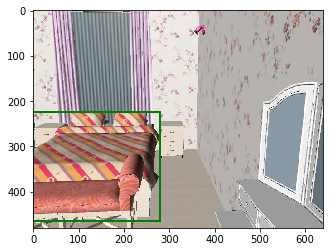

('prediction:', array([ 1.7917448 , -0.68750083,  0.49836782, -0.23839271, -0.20354268,
       -4.136708  ], dtype=float32), 0, 'Bed')


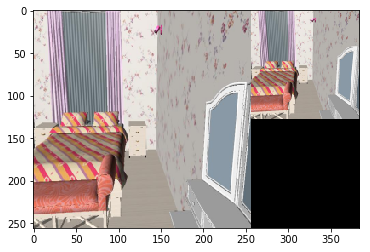

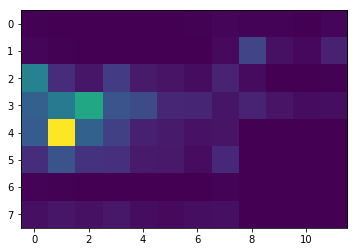

In [151]:
demo.visualize()

05:15:27 INFO:Baseline with bounding box crop estimated from both image and keyword


number of training image: 10742, number of testing image: 4605
('train', {3: 3396, 4: 5141, 5: 3711, 6: 3380, 13: 2604, 24: 1587}, 0.25939754780765933)
('test', {3: 1515, 4: 2152, 5: 1548, 6: 1383, 13: 1058, 24: 755}, 0.25585542741647843)


05:15:29 INFO:epoch 0, train loss: 1.81, average train loss: 1.81
05:15:29 INFO:epoch 0, train accuracy: 0.16, average train accuracy: 0.16
05:15:30 INFO:epoch 1, train loss: 1.80, average train loss: 1.80
05:15:30 INFO:epoch 1, train accuracy: 0.31, average train accuracy: 0.23
05:15:32 INFO:epoch 2, train loss: 1.84, average train loss: 1.82
05:15:32 INFO:epoch 2, train accuracy: 0.25, average train accuracy: 0.24
05:15:33 INFO:epoch 3, train loss: 1.81, average train loss: 1.82
05:15:33 INFO:epoch 3, train accuracy: 0.27, average train accuracy: 0.25
05:15:34 INFO:epoch 4, train loss: 1.80, average train loss: 1.81
05:15:34 INFO:epoch 4, train accuracy: 0.17, average train accuracy: 0.23
05:15:35 INFO:epoch 5, train loss: 1.77, average train loss: 1.80
05:15:35 INFO:epoch 5, train accuracy: 0.25, average train accuracy: 0.23
05:15:36 INFO:epoch 6, train loss: 1.80, average train loss: 1.80
05:15:36 INFO:epoch 6, train accuracy: 0.17, average train accuracy: 0.23
05:15:38 INFO:epoch 

('groundtruth:', array([1., 2., 1., 1.], dtype=float32), 1, 'Chair')


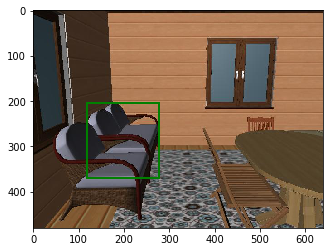

('prediction:', array([-0.18740073,  1.0088342 , -1.0963289 ,  0.02247539,  0.14533263,
       -1.4645611 ], dtype=float32), 1, 'Chair')


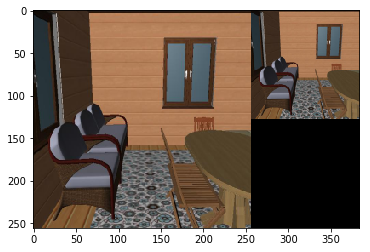

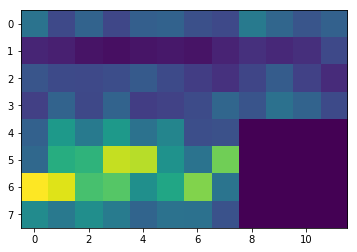

In [152]:
command = 'train'

learning_rate = 1e-3
train_epoch = 1000
test_epoch = 10
test_interval = 100
save_interval = 1001
save_dir = './'
batch_size = 64
im_size = [256, 128]
orig_im_size = [480, 640]
attn_size = [8, 4] 
im_channel = 3
direction_dim = 4
n_class = 6
tensorboard_path = './tensorboard/2d_base_direction_attn_comb_1'
init_model_path = ''
train_proportion = 1
statistics = 'basic'
direction_type = 'discrete'
demo = BaseDirectionAttnCombDemo(learning_rate, train_epoch, test_epoch, test_interval, save_interval, save_dir, 
                                 batch_size, im_size, orig_im_size, attn_size, im_channel, direction_dim, n_class, 
                                 tensorboard_path, init_model_path, train_proportion, statistics, direction_type)
if command == 'train':
    demo.train()
elif command == 'test':
    demo.test()
demo.test_all()
demo.visualize()

('groundtruth:', array([1., 3., 1., 1.], dtype=float32), 4, 'Desks')


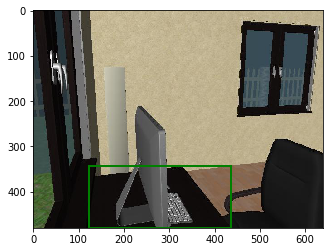

('prediction:', array([-0.82897735,  1.1421735 , -0.39531586, -0.06282976,  0.26103172,
       -1.4629184 ], dtype=float32), 1, 'Chair')


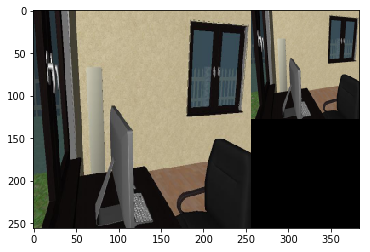

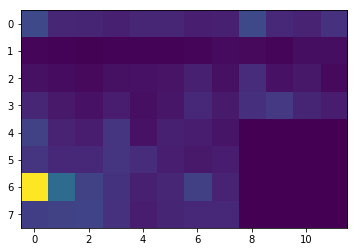

In [153]:
demo.visualize()